In [9]:
import logging
import pandas as pd
from simpletransformers.seq2seq import Seq2SeqModel, Seq2SeqArgs
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
import warnings
from transformers import AutoModelForSequenceClassification, AutoTokenizer, \
    RobertaTokenizer, RobertaForSequenceClassification
import evaluate
from tqdm.auto import tqdm
import torch
import numpy as np
from sklearn.metrics import mean_squared_error
from pathlib import Path

warnings.filterwarnings("ignore")
data_dir = Path("../data/interim")
models_dir = Path("../models")

model_path = models_dir / "bart-paraphrase-retrained"
dataset_path = data_dir / "formatted.parquet"
pred_1percent_path = data_dir / "pred_1percent.txt"
true_1percent_path = data_dir / "true_1percent.txt"
target_1percent_path = data_dir / "target_1percent.txt"
stats_path = data_dir / "eval_stats.parquet"

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [10]:
df = pd.read_parquet(dataset_path)
index = df.sample(frac=0.01, random_state=42).index
to_predict = df["reference"][index].parallel_apply(lambda x: x.lower()).tolist()
target = df["translation"][index].parallel_apply(lambda x: x.lower()).tolist()
df

,Unnamed: 0,reference,translation,similarity,lenght_diff,ref_tox,trn_tox,tox_diff,fit_score
0,194059,Hands on the fucking table!,hands on the table!,0.949878,0.285714,0.999351,0.000047,0.999304,0.949216
1,566611,Ha ha ha... shit!,ha ha ha...,0.949609,0.333333,0.999633,0.000067,0.999566,0.949197
2,401254,Finally something good about this fucking dise...,"finally, something good about this disease.",0.949981,0.137255,0.999520,0.000354,0.999166,0.949189
3,207219,a picture of a pyramid star and their fucking ...,Picture of a Pyramid star and their fracking t...,0.949892,0.016949,0.999298,0.000057,0.999241,0.949171
4,303258,Take your fucking shirt off.,take your shirt off.,0.949953,0.275862,0.999497,0.000344,0.999153,0.949149
...,...,...,...,...,...,...,...,...,...
463207,100001,On one bitter winter day you use said ax to be...,one chilly winter day with that axe you cut of...,0.618843,0.093750,0.910227,0.062810,0.847418,0.524419
463208,496723,and then the crazy robot with the bomb came.,And that's when that crazy robo killer flying ...,0.627935,0.357143,0.931676,0.096536,0.835141,0.524414
463209,362888,And this time things are gonna end differently...,"but this time, the duel will be different, you...",0.626956,0.086957,0.882351,0.045935,0.836416,0.524396
463210,162186,To crap all over my new life?,to make my life miserable?,0.645105,0.100000,0.830504,0.017620,0.812884,0.524396


In [11]:
model = Seq2SeqModel(encoder_decoder_type="bart", encoder_decoder_name=model_path)

In [13]:

predict = model.predict(to_predict)
predict = pd.Series(predict).parallel_apply(lambda x: x.lower()).tolist()
np.savetxt(pred_1percent_path, predict, fmt='%s', encoding="utf-8")

Generating outputs:   0%|          | 0/73 [00:00<?, ?it/s]

In [14]:
np.savetxt(true_1percent_path, to_predict, fmt='%s', encoding="utf-8")
np.savetxt(target_1percent_path, target, fmt='%s', encoding="utf-8")

In [15]:
toxicity = evaluate.load("toxicity", module_type="measurement")
pred_toxicity= toxicity.compute(predictions=predict)
pred_toxicity = pred_toxicity["toxicity"]

Using default facebook/roberta-hate-speech-dynabench-r4-target checkpoint


In [16]:
true_toxicity = toxicity.compute(predictions=to_predict)
true_toxicity = true_toxicity["toxicity"]

In [17]:
target_toxicity = toxicity.compute(predictions=target)
target_toxicity = target_toxicity["toxicity"]

In [19]:
stats = pd.DataFrame({"pred_tox": pred_toxicity,
                      "true_tox": true_toxicity,
                      "target_tox": target_toxicity,
                      "pred_sent": predict,
                      "true_sent": to_predict,
                      "target_sent": target})
stats.to_parquet(stats_path)

In [20]:
stats = pd.read_parquet(stats_path)

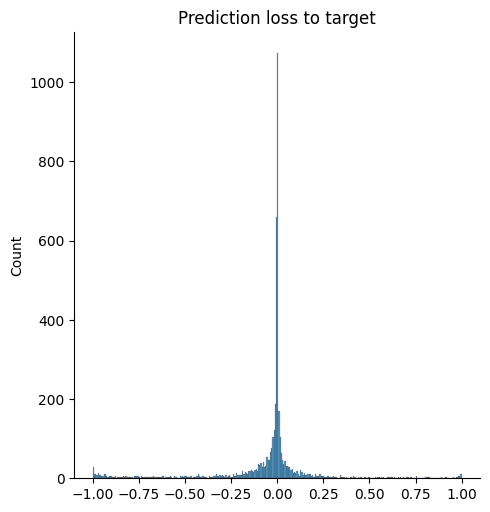

In [22]:
import seaborn as sns
from matplotlib import pyplot as plt

figures_dir = Path("../reports/figures")

plot = sns.displot((stats["target_tox"] - stats["pred_tox"]).sort_values())
title = "Prediction loss to target"
plt.title(title)

plot.figure.savefig(figures_dir / (title + ".png"))